In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3,0,1,2,4,5'

import numpy as np
import pandas as pd
import torch

from tqdm.auto import tqdm

BATCH_SIZE = 64
MIN_LONG_PROMPT_LENGTH = 150
MIN_LONG_PROMPT_TOKEN_LENGTH = 50
MAX_PROMPT_TOKEN_LENGTH = 150
MAX_TAG_LENGTH = 150

In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers import Trainer, TrainingArguments
from transformers import DataCollatorForLanguageModeling

# from peft import get_peft_model, LoraConfig, TaskType, prepare_model_for_int8_training

In [3]:
from prompt_datasets import PromptDataset, PairedPromptDataset, MultipleDataset

In [4]:
# # MODEL_PATH = 'crumb/bloom-560m-RLHF-SD2-prompter'
# MODEL_PATH = 'weight/bloom-560m-shuffle'

# tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH, local_files_only=True)
# tokenizer.padding_side = 'right'

In [5]:
# MODEL_PATH = 'FredZhang7/distilgpt2-stable-diffusion-v2'
MODEL_PATH = 'weight/distilgpt2-paired'
# MODEL_PATH = 'GPT2-new/checkpoint-25000/'

tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH, local_files_only=True)
tokenizer.pad_token = '\x7f'
tokenizer.pad_token_id = tokenizer('\x7f').input_ids[0]

## paired

In [19]:
prompt_file_paths = [
    '../dataset/nonredundant-civitai_prompts.tsv',
    # '../dataset/nonredundant-midjourney_prompts-paired.tsv',
    '../dataset/nonredundant-leonardo_prompts.tsv',
]

In [20]:
prompts = list()

for file_path in prompt_file_paths:
    df = pd.read_csv(file_path, sep='\t')
    prompts.append(df)
    
prompts = pd.concat(prompts, axis=0, ignore_index=True)
prompts.dropna(inplace=True)

In [21]:
prompts['positive_length'] = prompts['positive_prompt'].str.len()
prompts['negative_length'] = prompts['negative_prompt'].str.len()
# prompts.query(f'positive_length < {MIN_LONG_PROMPT_LENGTH} or negative_length < {MIN_LONG_PROMPT_LENGTH}', inplace=True)

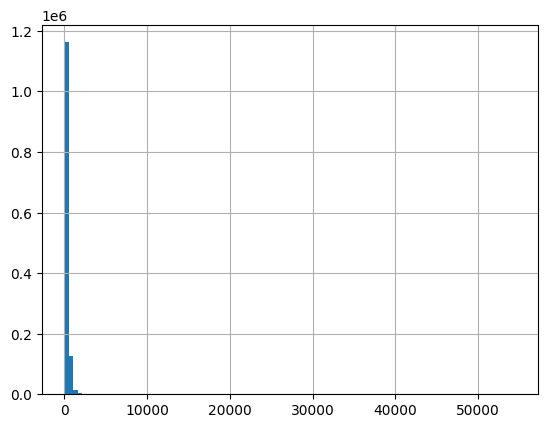

In [9]:
_ = prompts['negative_length'].hist(bins=100)

In [37]:
paired_dataset = PairedPromptDataset(prompts, tokenizer, p_shuffle=0.5, max_shuffle=3, p_cut=0.2, max_prompt_length=MAX_PROMPT_TOKEN_LENGTH, overflow_method='split')

  0%|          | 0/822390 [00:00<?, ?it/s]

## long paired

In [20]:
prompt_file_paths = [
    '../dataset/nonredundant-civitai_prompts.tsv',
    '../dataset/nonredundant-midjourney_prompts-paired.tsv',
    '../dataset/nonredundant-leonardo_prompts.tsv',
]

In [21]:
prompts = list()

for file_path in prompt_file_paths:
    df = pd.read_csv(file_path, sep='\t')
    prompts.append(df)
    
prompts = pd.concat(prompts, axis=0, ignore_index=True)
prompts.dropna(inplace=True)

In [22]:
prompts['positive_length'] = prompts['positive_prompt'].str.len()
prompts['negative_length'] = prompts['negative_prompt'].str.len()
# prompts.query(f'positive_length > {MIN_LONG_PROMPT_LENGTH} or negative_length > {MIN_LONG_PROMPT_LENGTH}', inplace=True)

In [28]:
long_paired_dataset = PairedPromptDataset(prompts, tokenizer, p_shuffle=0.5, max_shuffle=3, p_cut=0., min_prompt_length=MIN_LONG_PROMPT_TOKEN_LENGTH, max_prompt_length=MAX_PROMPT_TOKEN_LENGTH, overflow_method='split')

  0%|          | 0/995044 [00:00<?, ?it/s]

## single

In [43]:
prompt_file_paths = [
    # '../dataset/nonredundant-discord_prompts.tsv',
    # '../dataset/nonredundant-lexica_prompts-train.tsv',
    # '../dataset/nonredundant-lexica_prompts-eval.tsv',
    '../dataset/nonredundant-civitai_prompts.tsv',
    # '../dataset/nonredundant-leonardo_prompts.tsv',
]

In [44]:
prompts = list()

for file_path in prompt_file_paths:
    df = pd.read_csv(file_path, sep='\t')
    prompts.append(df)
    
prompts = pd.concat(prompts, axis=0, ignore_index=True)

In [29]:
prompts['positive_prompt'] = [i if (type(i) == str and max(map(len, i.split(','))) < MAX_TAG_LENGTH) else None for i in prompts['positive_prompt']]
prompts['negative_prompt'] = [i if (type(i) == str and max(map(len, i.split(','))) < MAX_TAG_LENGTH) else None for i in prompts['negative_prompt']]

In [45]:
prompts['positive_length'] = prompts['positive_prompt'].str.len()
prompts['negative_length'] = prompts['negative_prompt'].str.len()
# prompts.query(f'positive_length < {MIN_LONG_PROMPT_LENGTH} or negative_length < {MIN_LONG_PROMPT_LENGTH}', inplace=True)

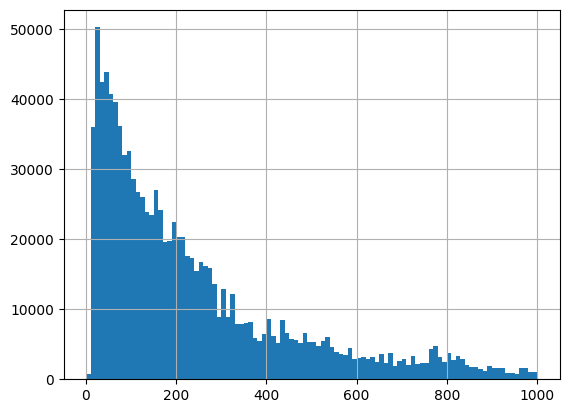

In [46]:
_ = prompts['negative_length'].dropna().hist(bins=100, range=(1, 1000))

In [46]:
single_dataset = PromptDataset(prompts, tokenizer, p_shuffle=0.5, max_shuffle=3, p_cut=0.2, max_prompt_length=MAX_PROMPT_TOKEN_LENGTH*2-1, overflow_method='split')

  0%|          | 0/3397810 [00:00<?, ?it/s]

# long single

In [39]:
prompt_file_paths = [
    '../dataset/nonredundant-discord_prompts.tsv',
    '../dataset/nonredundant-lexica_prompts-train.tsv',
    '../dataset/nonredundant-lexica_prompts-eval.tsv',
    # '../dataset/nonredundant-civitai_prompts.tsv',
    '../dataset/nonredundant-leonardo_prompts.tsv',
    '../dataset/nonredundant-dalle_captions.tsv',
    '../dataset/nonredundant-dalle_chatgpt_prompts.tsv',
    '../dataset/nonredundant-dalle_discord_prompts.tsv',
    '../dataset/nonredundant-midjourney_prompts-paired.tsv',
    '../dataset/long-laion2B-en-aesthetic.tsv',
    '../dataset/long-midjourney_prompts.tsv',
    '../dataset/long-midjourney_prompts-2.tsv',
]

In [7]:
prompts = list()

for file_path in prompt_file_paths:
    df = pd.read_csv(file_path, sep='\t')
    prompts.append(df)
    
prompts = pd.concat(prompts, axis=0, ignore_index=True)
prompts.fillna('', inplace=True)

In [12]:
prompts['positive_length'] = prompts['positive_prompt'].str.len()
prompts['negative_length'] = prompts['negative_prompt'].str.len()
prompts.query(f'positive_length > {MIN_LONG_PROMPT_LENGTH} or negative_length > {MIN_LONG_PROMPT_LENGTH}', inplace=True)

In [18]:
long_single_dataset = PromptDataset(prompts, tokenizer, p_shuffle=0.5, max_shuffle=3, p_cut=0., min_prompt_length=MIN_LONG_PROMPT_TOKEN_LENGTH, max_prompt_length=MAX_PROMPT_TOKEN_LENGTH*2-1, overflow_method='split')

  0%|          | 0/2592684 [00:00<?, ?it/s]

## extend

In [47]:
prompt_file_paths = [
    '../dataset/nonredundant-dalle_captions.tsv',
    '../dataset/nonredundant-dalle_chatgpt_prompts.tsv',
    '../dataset/nonredundant-dalle_discord_prompts.tsv',
    '../dataset/nonredundant-midjourney_prompts-paired.tsv',
]

In [48]:
prompts = list()

for file_path in prompt_file_paths:
    df = pd.read_csv(file_path, sep='\t')
    prompts.append(df)
    
prompts = pd.concat(prompts, axis=0, ignore_index=True)

In [49]:
prompts['positive_prompt'] = [i if (type(i) == str and max(map(len, i.split(','))) < MAX_TAG_LENGTH) else None for i in prompts['positive_prompt']]
prompts['negative_prompt'] = [i if (type(i) == str and max(map(len, i.split(','))) < MAX_TAG_LENGTH) else None for i in prompts['negative_prompt']]

In [50]:
extend_dataset = PromptDataset(prompts, tokenizer, p_shuffle=0.25, max_shuffle=2, p_cut=0.1, max_prompt_length=MAX_PROMPT_TOKEN_LENGTH*2-1, overflow_method='split')

  0%|          | 0/1321952 [00:00<?, ?it/s]

In [51]:
extend_dataset.samples += [(torch.tensor(i), True) for i in np.load('sampled_aesthetic.npy', allow_pickle=True) if len(i) < extend_dataset.max_prompt_length]
extend_dataset.samples += [(torch.tensor(i), True) for i in np.load('sampled_midjourney.npy', allow_pickle=True) if len(i) < extend_dataset.max_prompt_length]

# merge

In [54]:
merged_dataset = MultipleDataset([paired_dataset, long_paired_dataset, single_dataset, long_single_dataset, extend_dataset], probabilities=[0.15, 0.3, 0.1, 0.15, 0.3])
len(paired_dataset), len(long_paired_dataset), len(single_dataset), len(long_single_dataset), len(extend_dataset), len(merged_dataset)

(711395, 1396772, 3408587, 2124010, 6968912, 6968912)

In [55]:
len_val_set = int(len(merged_dataset) * 0.001)
train_set, val_set = torch.utils.data.random_split(merged_dataset, (len(merged_dataset) - len_val_set, len_val_set))

In [56]:
data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)

In [57]:
model = AutoModelForCausalLM.from_pretrained(MODEL_PATH, local_files_only=True)

In [24]:
# model = AutoModelForCausalLM.from_pretrained(MODEL_PATH, local_files_only=True, load_in_8bit=True, device_map='auto')
# model = prepare_model_for_int8_training(model)

In [25]:
# peft_config = LoraConfig(
#     task_type=TaskType.CAUSAL_LM, inference_mode=False, r=16, lora_alpha=16, lora_dropout=0.1, bias="all"
# )

In [26]:
# model = get_peft_model(model, peft_config)
# model.print_trainable_parameters()

In [63]:
args = TrainingArguments(
    output_dir="GPT2-paired",
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    logging_steps=1_000,
    gradient_accumulation_steps=4,
    num_train_epochs=3,
    weight_decay=0.1,
    warmup_steps=1_000,
    lr_scheduler_type="cosine",
    learning_rate=1e-4,
    save_steps=5_000,
    fp16=True,
    
    push_to_hub=False,
    
    evaluation_strategy="steps",
    eval_steps=1_000,
    do_eval=True,
)

In [64]:
trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=args,
    data_collator=data_collator,
    train_dataset=train_set,
    eval_dataset=val_set,
)

In [65]:
trainer.train()

/sunjie/kcg-ml-image-pipeline/venv/lib/python3.10/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
1000,1.263800,1.184049
2000,1.262300,1.170541
3000,1.257700,1.184240
4000,1.248600,1.155769
5000,1.242600,1.159461
6000,1.239300,1.153006
7000,1.234100,1.113917
8000,1.233800,1.150632
9000,1.227000,1.137126
10000,1.223500,1.124482


/sunjie/kcg-ml-image-pipeline/venv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


TrainOutput(global_step=13596, training_loss=1.23724769262329, metrics={'train_runtime': 66949.627, 'train_samples_per_second': 311.963, 'train_steps_per_second': 0.203, 'total_flos': 1.6362499120213524e+18, 'train_loss': 1.23724769262329, 'epoch': 3.0})

In [66]:
tokenizer.save_pretrained('weight/distilgpt2-paired')

('weight/distilgpt2-paired/tokenizer_config.json',
 'weight/distilgpt2-paired/special_tokens_map.json',
 'weight/distilgpt2-paired/vocab.json',
 'weight/distilgpt2-paired/merges.txt',
 'weight/distilgpt2-paired/added_tokens.json',
 'weight/distilgpt2-paired/tokenizer.json')

In [67]:
model.save_pretrained('weight/distilgpt2-paired')